Author : Dr. Maria B. Stone

Topic: A minimal code example for correcting one SFR estimator to the baseline of another, for my research project based on GAMA spectroscopic survey


# Code to correct SFR values from one estimator to the baseline of another, via Chebyshev fit, with visualizations

start by importing the necessary packages

In [1]:
import numpy as np
from astropy import units as u
from astropy.table import QTable, Table

#for Chebyshev fit
from numpy.polynomial import Chebyshev

# for plotting
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline

## Background and preparatory work

In this paper, we have two SFR estimators: CIGALE-based and MAGPHYS-based.
Both CIGALE and MAGPHYS are tools to model the spectral energy distribution of a galaxy.
https://cigale.lam.fr/documentation/
https://www.iap.fr/magphys/

The quasar sample in this paper does not have reliable MAGPHYS estimates, only CIGALE-based estimates for SFR parameter.
The control sample of galaxies has SFR estimates from both methods, on the other hand,
so it is used to obtain a correction curve to bring the quasar sample value to MAGPHYS baseline.
Thus, the Chebyshev fit correction for SFR is based on the data of a control sample of galaxies.

We first calculate the offsets between the two SFR values for each galaxy in the control sample, 

offset = $\Delta$SFR = SFR$_{CIGALE}$ - SFR$_{MAGPHYS}$

All SFR values are expressed in log(10). 
The units of SFR are in solar masses per year.

Next, we identified median offset values per dex of SFR$_{CIGALE}$ for control galaxies.

The data regarding these median offset points for normal galaxies is saved in the file
'sfroffset.fits'.

----------

## Step 1. Performing the Chebyshev fit to obtain a correction curve

We load the data from the information about median offsets.

In [2]:
datafit = Table.read('sfroffset.fits')

In [3]:
datafit

controlgx_SFRCIGALE_dexbins,controlgx_SFRoffset_binmedians,controlgx_SFRoffset_medianerr,weights
float64,float64,float64,float64
-1.5,0.1103074128,0.10677294633648178,9.36566831122767
-0.5,-0.10990611115,0.04481095382985617,22.315972201728286
0.5,-0.05672812033,0.029500705794967375,33.89749407861941
1.5,-0.0026995360099999997,0.06102578321679179,16.38651644088758


In this case we choose Chebyshev fit to construct the correction curve.
We choose a conservative degree value for the fit.

In [4]:
degree = 2

sfr_cheb_curve = Chebyshev.fit(datafit['controlgx_SFRCIGALE_dexbins'],\
                          datafit['controlgx_SFRoffset_binmedians'], \
                          deg=degree, w=datafit['weights'])


We apply the Chebyshev fit only to the values within its domain.

In [5]:
sfr_min, sfr_max = sfr_cheb_curve.domain
print (sfr_min, sfr_max)

-1.5 1.5


------------

## Step 2. Apply the correction to obtained the corrected SFR estimates for the quasar sample

We need to apply corrected offsets to quasars.
We use a small subset of the actual sample in the paper, for illustration in this code.
The obtained correction curve helps us to adjust quasar CIGALE values to get the SFR values on Magphys baseline for quasars.


We load the data for a subsample of quasars.

In [6]:
data_quasars = Table.read('quasar_subsample_sfrcigale.fits')

In [7]:
data_quasars[:3]

SFR CIGALE
solMass / yr
float64
0.65634209645293
0.8330261488174954
0.7629098295106881


We clip the data to make sure that the fit is applied within our fit's domain range only.
The points outside of the domain will get the fit value of the endpoint.

In [8]:
sfr_clipped = np.clip(data_quasars['SFR CIGALE'], sfr_min, sfr_max)

We can calculate then the corrected offset by applying the Chebyshev fit obtained above to quasar CIGALE-based SFR values in this subsample.

In [9]:
sfr_offset_corrected = sfr_cheb_curve (sfr_clipped)

This corrects the CIGALE SFR values to MAGPHYS baseline.


In [10]:
sfr_quasars_corrected = data_quasars['SFR CIGALE'] - sfr_offset_corrected

In [11]:
# Let's peek into the created table of corrected SFR values for quasars

sfr_quasars_corrected[:4]

0.7220012569253578
0.886228397758161
0.8214302400902835
-0.2832422251624514


In [12]:
# Let's save into a new table, with units
table_sfrcorrected = QTable()
table_sfrcorrected['log10(SFR) corrected'] = sfr_quasars_corrected
table_sfrcorrected[:3]

log10(SFR) corrected
solMass / yr
float64
0.7220012569253578
0.886228397758161
0.8214302400902835


In [13]:
# Save the new table as a FITS file
table_sfrcorrected.write('quasars_sfrcorrected.fits',overwrite=True)

## Step 3. Visuals to illustrate the method

Let's first look at a histogram

In [14]:
# define bins for the histogram
# I use min and max of the property to identify the edges
# And I choose a bin number as well for the histogram here

bins_low = np.min(sfr_quasars_corrected)
bins_high = np.max(sfr_quasars_corrected)
nbins = 5

In [15]:
# get the binEdges and the bin width for the histogram
counts_galaxies_all, binEdges_all = np.histogram\
    (sfr_quasars_corrected, bins=nbins, range=(bins_low,bins_high))

bincenters_all = 0.5*(binEdges_all[1:]+binEdges_all[:-1])

bin_width_all = (binEdges_all[1]-binEdges_all[0])

fraction_galaxies_all = counts_galaxies_all/len(sfr_quasars_corrected) # bin width

count_errors = np.sqrt(counts_galaxies_all)/len(sfr_quasars_corrected) # Poisson error


In [16]:
binEdges_all

array([-0.62952036, -0.25687939,  0.11576158,  0.48840256,  0.86104353,
        1.2336845 ])

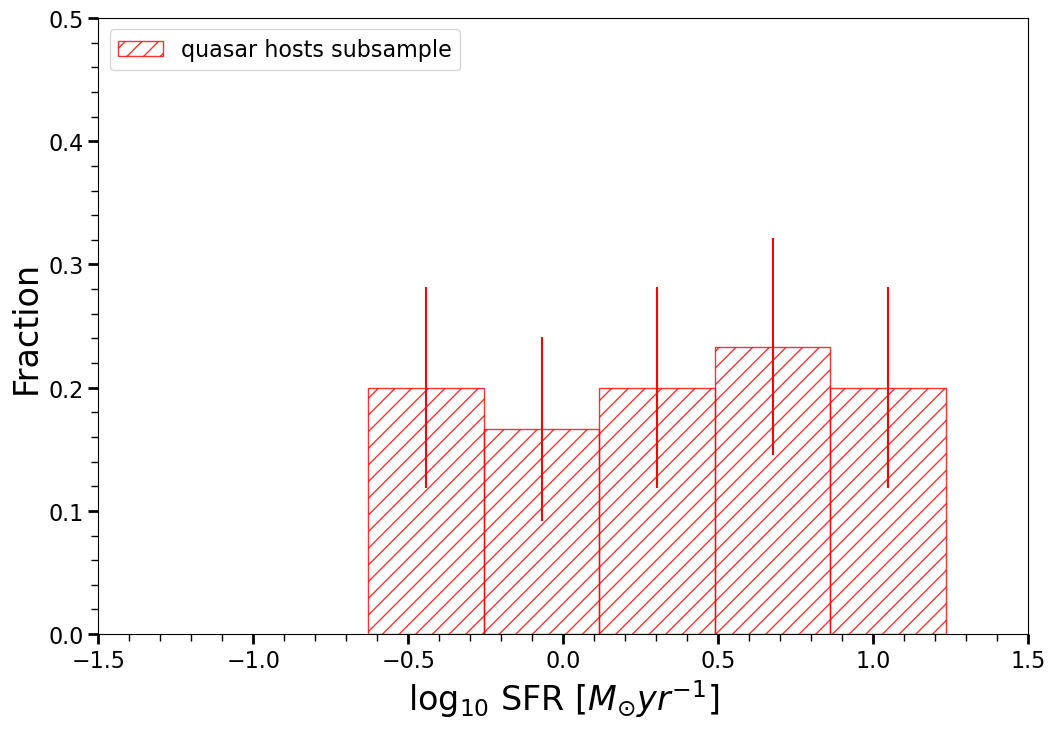

In [17]:
plt.figure(figsize=(12,8))

plt.bar(bincenters_all, fraction_galaxies_all, yerr=count_errors, width=bin_width_all,\
                 color='None', ecolor='red', hatch='//', alpha=0.8, edgecolor='red', \
        linewidth=1, label='quasar hosts subsample')

plt.ylabel('Fraction', fontsize=24)
plt.xlabel('log$_{10}$ SFR [$M_{\odot} yr^{-1}$]',fontsize=24)

plt.legend(fontsize=16, loc='upper left')

# I put limits outside the range a bit, to bring more white space around the graph
# to ease the eye

plt.ylim(0,0.5)
plt.xlim(-1.5,1.5)

plt.locator_params(axis='x', nbins=10)
plt.locator_params(axis='y', nbins=5)

plt.minorticks_on()
plt.tick_params(axis='both',length=7,width=2,labelsize=16)
plt.tick_params(axis='both',which='minor',length=5,width=1)

plt.savefig("figure_histogram.pdf")

Let's visualize the fit over the originally fitted points

In [18]:
# We generate a bunch of consecutive points within the domain of the fit
# This will allow our eyes to perceive a continuous curve (approximately)
# We calculate the Chebyshev fit values

points_x_cheb = np.arange(-1.51, 1.51, 0.1)
points_y_cheb = sfr_cheb_curve(points_x_cheb)

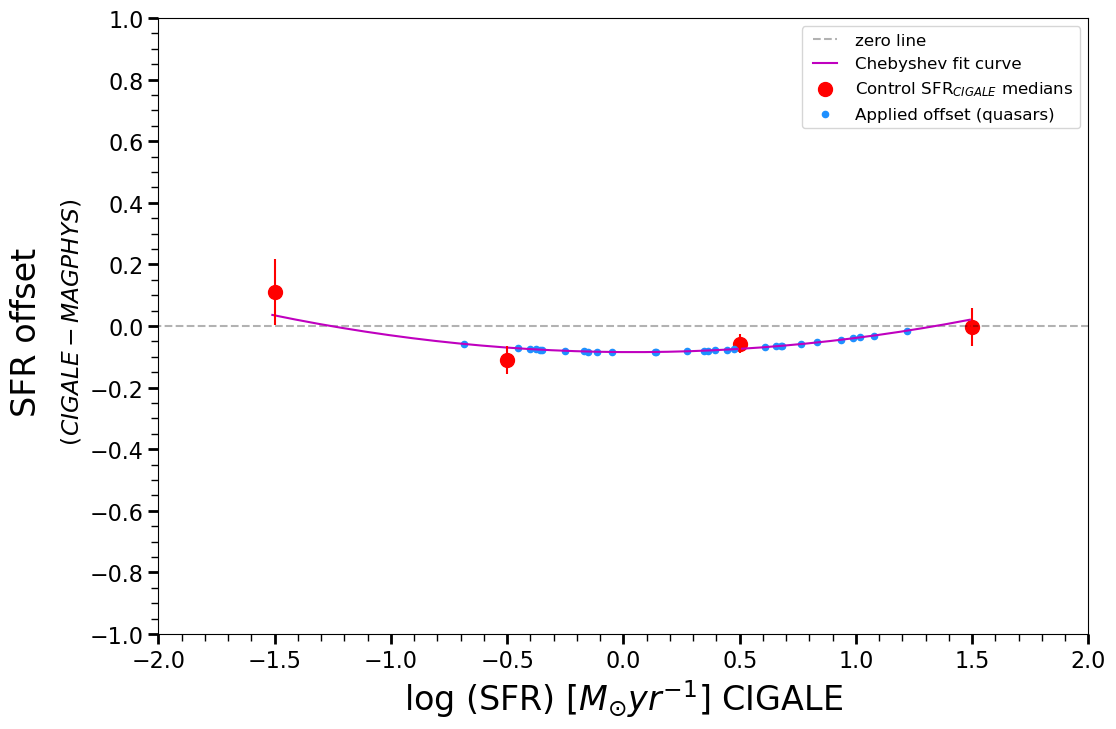

In [19]:
plt.figure(figsize=(12,8))

# Zero line for reference
plt.plot([-5,5],[0,0], 'k--', label='zero line', alpha=0.3)

# Fitted Chebyshev curve
plt.plot(points_x_cheb, points_y_cheb,'m-',label='Chebyshev fit curve')

# Control sample (binned medians with uncertainty)
plt.scatter(datafit['controlgx_SFRCIGALE_dexbins'],\
            datafit['controlgx_SFRoffset_binmedians'], 
            s=100, edgecolor='red', color='red', label='Control SFR$_{CIGALE}$ medians')
plt.errorbar(datafit['controlgx_SFRCIGALE_dexbins'],\
            datafit['controlgx_SFRoffset_binmedians'], \
             datafit['controlgx_SFRoffset_medianerr'],\
             ms=10,color='red', ls='none', barsabove='True')


# Quasar points: before correction (evaluate offset)
plt.scatter(data_quasars['SFR CIGALE'], sfr_offset_corrected, s=20, color='dodgerblue',
            label='Applied offset (quasars)')


plt.xlabel('log (SFR) [$M_{\odot} yr^{-1}$] CIGALE', fontsize=24)
plt.ylabel('SFR offset \n $_{(CIGALE-MAGPHYS)}$', fontsize=24)


plt.legend(fontsize=12, loc='best', numpoints = 3)

plt.ylim(-1,1)
plt.xlim(-2,2)

plt.locator_params(axis='x', nbins=10)
plt.locator_params(axis='y', nbins=10)

plt.minorticks_on()
plt.tick_params(axis='both',length=7,width=2,labelsize=16)
plt.tick_params(axis='both',which='minor',length=5,width=1)

plt.savefig("figure_fit_demo.pdf")

Another check for the CIGALE to MAGPHYS SFR correction step

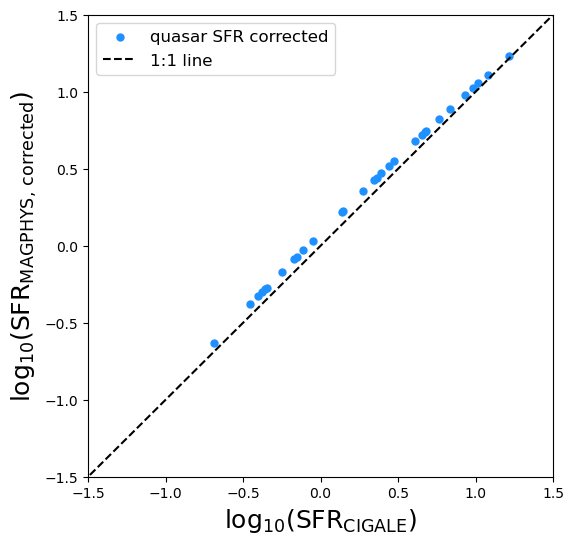

In [20]:
plt.figure(figsize=(6,6))

plt.scatter(data_quasars['SFR CIGALE'], sfr_quasars_corrected, s=25, c='dodgerblue', label='quasar SFR corrected')
plt.plot([-3, 3], [-3, 3], 'k--', label='1:1 line')  # reference

plt.xlabel(r'$\log_{10}(\mathrm{SFR_{CIGALE}})$', fontsize=18)
plt.ylabel(r'$\log_{10}(\mathrm{SFR_{MAGPHYS,\,corrected}})$', fontsize=18)
plt.legend(loc='best', fontsize=12)

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

plt.savefig("figure_corrections.pdf")

In [21]:
# end